# Analysis of MPI-IO wite peformance: benchio

Results of benchio MPI-IO write performance on a range of systems

## Setup and helper functions

Import the required Python modules

In [69]:
import sys
import os.path
import re
from glob import glob

import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
sns.set_context("paper")

Function to read the data from the data from benchio output

In [70]:
def getperf(filename):
    resframe_proto = []
    infile = open(filename, 'r')
    resdict = {}
    for line in infile:
        if re.search('MPI-IO', line):
            break
        elif re.search('Starting job', line):
            tokens = line.split()
            resdict['JobID'] = tokens[2]
        elif re.search('Running', line):
            tokens = line.split()
            resdict['Writers'] = int(tokens[2])
        elif re.search('Array', line):
            tokens = line.split()
            x = int(tokens[4])
            y = int(tokens[6])
            z = int(tokens[8])
            resdict['LocalSize'] = x
        elif re.search('Global', line):
            tokens = line.split()
            x = int(tokens[4])
            y = int(tokens[6])
            z = int(tokens[8])
            resdict['GlobalSize'] = x
        elif re.search('Total', line):
            tokens = line.split()
            resdict['TotData'] = float(tokens[5])
    infile.close()
    infile = open(filename, 'r')
    timedict = resdict.copy()
    inmpiio = False
    for line in infile:
        if inmpiio:
            if re.search('HDF5', line):
                inmpiio = False
                break
            elif re.search('Writing to', line):
                tokens = line.split()
                nstripe = 0
                if re.match('striped', tokens[2]):
                    timedict['Striping'] = -1
                    nstripe = -1
                elif re.match('defstriped', tokens[2]):
                    timedict['Striping'] = 4
                    nstripe = 4
                elif re.match('unstriped', tokens[2]):
                    timedict['Striping'] = 1
                    nstripe = 1
            elif re.match(' time', line):
                tokens = line.split()
                timedict['Write'] = float(tokens[6])
                timedict['File'] = os.path.abspath(filename)
                timedict['Count'] = 1
                resframe_proto.append(timedict)
                curstriping = timedict['Striping']  
                timedict = resdict.copy()
                timedict['Striping'] = curstriping
        else:
            if re.search('MPI-IO', line):
                inmpiio = True
    infile.close()
    
    return resframe_proto

Small funtion to read data from a list of files and create a pandas dataframe with the performance data

In [71]:
def create_df(filelist):
    df_list = []
    for file in filelist:
        df_list.extend(getperf(file))
    return pd.DataFrame(df_list)   

Function to get a list of files in specified directory with specified prefix

In [72]:
def get_filelist(dir, stem):
    """
    Get list of date files in the specified directory
    """

    files = []
    if os.path.exists(dir):
        files = glob(os.path.join(dir, stem + '*' ))
        files.sort()
    else:
        sys.stderr.write("Directory does not exist: {1}".format(dir))
        sys.exit(1)

    return files

Function to analyse the dataframe and extract required stats as lists for plotting. Optionally prints a summary of the performance statistics.

In [73]:
def get_perf_stats(df, striping, localsize, stat, writestats=False):
    query = '(Striping == {0} & (LocalSize == {1}))'.format(striping, localsize)
    df_q = df.query(query)
    df_num = df_q.drop(['File', 'GlobalSize', 'TotData'], 1)
    groupf = {'Write':['min','median','max','mean'], 'Count':'sum'}
    df_group = df_num.sort_values(by='Writers').groupby(['Writers', 'Striping', 'LocalSize']).agg(groupf)
    if writestats:
        print(df_group)
    writeperf = df_group['Write',stat].tolist()
    writers = df_group.index.get_level_values(0).tolist()
    return writers, writeperf

## ARCHER

Results from ARCHER fs3 (Cray Sonexion Lustre) maximal striping, 256^3 local data size

In [74]:
resdir = '../results/ARCHER'
files = get_filelist(resdir, "benchio_")
archer_res = create_df(files)
# Restrict to just 256^3 results
query = '(LocalSize == {0})'.format(256)
archer_res = archer_res.query(query)

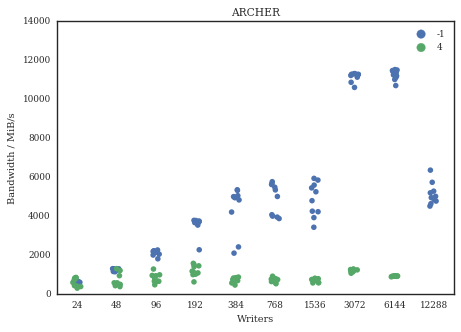

In [75]:
fig, ax = plt.subplots()

sns.stripplot(x='Writers', y='Write', data=archer_res, hue='Striping', jitter=True)
ax.set_ylim(ymin=0)

plt.ylabel('Bandwidth / MiB/s')
plt.xlabel('Writers')
plt.title('ARCHER')
plt.legend()

In [85]:
archer_writers, archer_maxwrite = get_perf_stats(archer_res, -1, 256, 'max', writestats=True)
archer_writers, archer_medwrite = get_perf_stats(archer_res, -1, 256, 'median')

                                   Write                              \
                                     min        median           max   
Writers Striping LocalSize                                             
24      -1       256          609.242149    640.324503    661.667327   
48      -1       256         1153.616446   1263.887274   1310.712323   
96      -1       256         1818.127449   2167.191612   2270.360488   
192     -1       256         2280.798789   3720.000888   3790.923948   
384     -1       256         2108.893877   4969.245834   5359.534893   
768     -1       256         3883.024015   5185.451164   5775.287425   
1536    -1       256         3436.416729   5028.897872   5945.990189   
3072    -1       256        10613.671551  11278.547575  11320.886446   
6144    -1       256        10708.537982  11304.231941  11529.934143   
12288   -1       256         4522.588702   4990.104913   6367.598176   

                                         Count  
              

## Cirrus

Results from Cirrus (DDN Lustre) 256^3 local data size

In [77]:
resdir = '../results/Cirrus'
files = get_filelist(resdir, "benchio_")
cirrus_res = create_df(files)

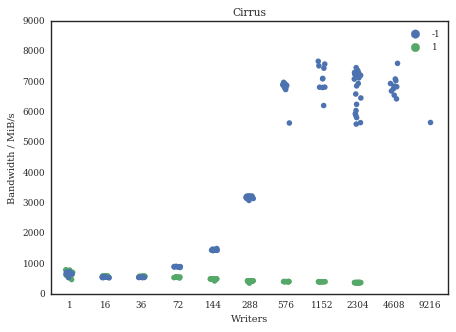

In [78]:
fig, ax = plt.subplots()

sns.stripplot(x='Writers', y='Write', data=cirrus_res, hue='Striping', jitter=True)
ax.set_ylim(ymin=0)

plt.ylabel('Bandwidth / MiB/s')
plt.xlabel('Writers')
plt.title('Cirrus')
plt.legend()

In [79]:
resdir = '../results/Cirrus'
files = get_filelist(resdir, "benchio_")
cirrus_res = create_df(files)

In [86]:
cirrus_writers, cirrus_maxwrite = get_perf_stats(cirrus_res, -1, 256, 'max', writestats=True)
cirrus_writers, cirrus_medwrite = get_perf_stats(cirrus_res, -1, 256, 'median')

                                  Write                            \
                                    min       median          max   
Writers Striping LocalSize                                          
1       -1       256         546.931164   677.231551   735.882143   
16      -1       256         544.581367   561.247480   571.380433   
36      -1       256         548.857362   556.490015   572.148949   
72      -1       256         882.584048   907.302454   915.846547   
144     -1       256        1437.682851  1466.758103  1506.970847   
288     -1       256        3094.565797  3199.662248  3240.886716   
576     -1       256        5648.993752  6883.934438  6990.985356   
1152    -1       256        6225.530317  7114.246634  7685.589335   
2304    -1       256        5612.660332  6912.794964  7474.470739   
4608    -1       256        6445.256527  6856.622290  7617.000845   
9216    -1       256        5671.240679  5671.240679  5671.240679   

                                 

## CSD3

Results from CSD3 (Intel Lustre) 256^3 local data size

In [81]:
resdir = '../results/CSD3Skylake'
files = get_filelist(resdir, "benchio_")
csd3_res = create_df(files)

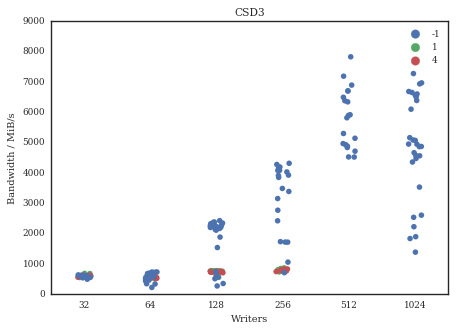

In [82]:
fig, ax = plt.subplots()

sns.stripplot(x='Writers', y='Write', data=csd3_res, hue='Striping', jitter=True)
ax.set_ylim(ymin=0)

plt.ylabel('Bandwidth / MiB/s')
plt.xlabel('Writers')
plt.title('CSD3')
plt.legend()

In [87]:
csd3_writers, csd3_maxwrite = get_perf_stats(csd3_res, -1, 256, 'max', writestats=True)
csd3_writers, csd3_medwrite = get_perf_stats(csd3_res, -1, 256, 'median')

                                  Write                            \
                                    min       median          max   
Writers Striping LocalSize                                          
32      -1       256         495.391617   604.803836   636.878110   
64      -1       256         223.516885   619.982881   734.525128   
128     -1       256         272.915353  2193.856663  2426.772131   
256     -1       256         711.355222  3671.515853  4319.454011   
512     -1       256        4525.734573  5859.905924  7832.476586   
1024    -1       256        1388.155565  4950.487578  7280.052396   

                                        Count  
                                   mean   sum  
Writers Striping LocalSize                     
32      -1       256         596.340637    20  
64      -1       256         585.273656    20  
128     -1       256        1860.948735    30  
256     -1       256        3151.127936    20  
512     -1       256        5802.721034   

## Comparison

Compare maximum and median write performance for maximum striping across all systems.

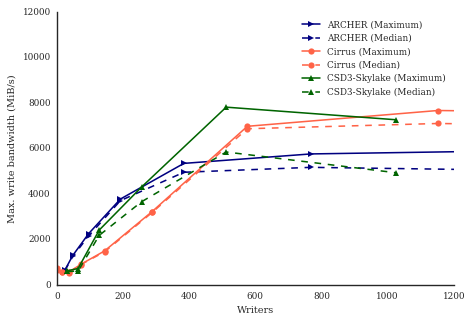

In [88]:
fig, ax = plt.subplots()
plt.plot(archer_writers, archer_maxwrite, '>-', color='navy', label='ARCHER (Maximum)')
plt.plot(archer_writers, archer_medwrite, '>--', color='navy', label='ARCHER (Median)')
plt.plot(cirrus_writers, cirrus_maxwrite, 'go-', color='tomato', label='Cirrus (Maximum)')
plt.plot(cirrus_writers, cirrus_medwrite, 'go--', color='tomato', label='Cirrus (Median)')
plt.plot(csd3_writers, csd3_maxwrite, 'r^-', color='darkgreen', label='CSD3-Skylake (Maximum)')
plt.plot(csd3_writers, csd3_medwrite, 'r^--', color='darkgreen', label='CSD3-Skylake (Median)')
plt.xlabel('Writers')
plt.ylabel('Max. write bandwidth (MiB/s)')
plt.xlim(0,1200)
plt.legend(loc='best')
sns.despine()